<a href="https://colab.research.google.com/github/marianfoo/ShopDataML/blob/master/notebooks/Aufgabe_Shopdaten_Feature_Selection_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Daten importieren

- transact_train   = Transaktionsdaten zum trainieren
- transact_class   = aktuelle Transaktionsdaten zum testen
- realclass_t1     = "Lösung" der transact_class ob Käufer oder nicht

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [0]:
transact_train = pd.read_csv('https://raw.githubusercontent.com/marianfoo/ShopDataML/master/data/transact_train.txt', sep='|', na_values='?')
transact_class = pd.read_csv('https://raw.githubusercontent.com/marianfoo/ShopDataML/master/data/transact_class.txt', sep='|', na_values='?')
realclass_t1 = pd.read_csv('https://raw.githubusercontent.com/marianfoo/ShopDataML/master/data/realclass_t1.txt', sep='|', na_values='?')

# Klassifizierung der Testdaten an Testdaten anhängen

In [0]:
transact_class = pd.merge(transact_class, realclass_t1, on='sessionNo').rename(columns={'prediction': 'order'})

# Reduzierung der Trainingsdaten falls notwendig

In [0]:
def down_size_data(factor, df):
    print('Shape of dataframe before down sizing with factor' + str(factor) +':' + str(df.shape))
    sampleSize = int(len(df.index) * factor)
    df = df.sample(sampleSize)
    print('Shape of dataframe after down sizing with factor' + str(factor) + ':' + str(df.shape))
    return df

In [5]:
transact_train = down_size_data(0.01,transact_train)

Shape of dataframe before down sizing with factor0.01:(429013, 24)
Shape of dataframe after down sizing with factor0.01:(4290, 24)


# Daten des Typs 'String' in integer umwandeln

In [0]:
def mapping_values(df):
    if df['order'].dtype == 'object':
        df['order'] = df['order'].map({'y': 1, 'n': 0})
    df['onlineStatus'] = df['onlineStatus'].map({'y': 1, 'n': 0})
    df['availability'] = df['availability'].map({
        'completely orderable': 1, 'completely not orderable': 2, 'mainly orderable': 3,
        'mixed': 4, 'completely not determinable': 5, 'mainly not orderable': 6, 'mainly not determinable': 7
    })

In [0]:
mapping_values(transact_train)
mapping_values(transact_class)

# Kundennr. hat keine Relevanz

In [0]:
transact_train.drop('customerNo', axis=1, inplace=True)
transact_class.drop('customerNo', axis=1, inplace=True)

# Spalte 'sessionNo' als Index für Dataframe nutzen

In [0]:
transact_train.set_index('sessionNo', inplace=True)
transact_class.set_index('sessionNo', inplace=True)

# Neue Daten aus den vorhanden Spalten erzeugen

# Leere Spalten erzeugen zum füllen 

In [0]:
import numpy as np
def add_columns(copy):
    df = copy.copy()
    df['maxBStep'] = np.nan
    df['avgBStep'] = np.nan
    df['countTransact'] = np.nan
    df['maxAvailability'] = np.nan
    df['maxOnlineStatus'] = np.nan
    df['avgAvailability'] = np.nan
    df['minOnlineStatus'] = np.nan
    df['minAvailability'] = np.nan
    # sicherstellen das order in der letzten Spalte ist
    df = df.reindex(columns=(list([a for a in df.columns if a != 'order']) + ['order'] ))
    return df

In [0]:
transact_train = add_columns(transact_train)
transact_class = add_columns(transact_class)

# Daten erzeugen

In [0]:
def fill_columns(added_df):
    # Serie erzeugen mit allen unique Session Nummern
    unique_sessions = added_df.index.unique().sort_values()
    # Loop durch alle Session Nummern [1,2,3,4,....]
    for session in unique_sessions:
        if session % 1000 == 0:
            print(str(session))
        # Alle Zeilen mit der Session Nummer
        rows = added_df.loc[added_df.index == session]
        # Maximale Nummer Schritt in der Einkaufsabwicklung
        maxBStep = rows['bStep'].max()
        # Durchschn. Nummer Schritt in der Einkaufsabwicklung
        avgBStep = rows['bStep'].mean()
        # Anzahl der Transaktionen der Sessionnr.
        countTransact = len(rows.index)
        # Max. Zahl der Produktsverfügbarkeit
        maxAvailability = rows['availability'].max()
        # Min. Zahl der Produktsverfügbarkeit
        minAvailability = rows['availability'].min()
        # Durchschn. Zahl der Produktsverfügbarkeit
        avgAvailability = rows['availability'].mean()
        # Max. Zahl der Online Status (0 oder 1)
        maxOnlineStatus = rows['onlineStatus'].max()
        # Min. Zahl der Online Status (0 oder 1)
        minOnlineStatus = rows['onlineStatus'].min()
        added_df.loc[added_df.index == session,'maxBStep'] = maxBStep
        added_df.loc[added_df.index == session,'avgBStep'] = avgBStep
        added_df.loc[added_df.index == session,'countTransact'] = countTransact
        added_df.loc[added_df.index == session,'maxAvailability'] = maxAvailability
        added_df.loc[added_df.index == session,'minAvailability'] = minAvailability
        added_df.loc[added_df.index == session,'avgAvailability'] = avgAvailability
        added_df.loc[added_df.index == session,'maxOnlineStatus'] = maxOnlineStatus
        added_df.loc[added_df.index == session,'minOnlineStatus'] = minOnlineStatus

In [13]:
fill_columns(transact_train)
fill_columns(transact_class)

4000
7000
11000
17000
37000
1000
2000
3000
4000
5000


## Leere Zeilen mit verschiedene Zahlen füllen
## mean = Mittelwert der jeweiligen Spalte
## median = Median der jeweiligen Spalte
## mode = Modi der einzelnen Elemente entlang der ausgewählten Achse

In [0]:
def fill_null_values(df, mode):
    if mode == 'mean':
        df = df.fillna(value=df.mean())
        print('Filled null values with mean')
    if mode == 'median':
        df = df.fillna(value=df.median())
        print('Filled null values with median')
    if mode == 'mode':
        df = df.fillna(value=df.mode().iloc[0])
        print('Filled null values with mode')
    return df

# Für Traingsdaten und Testdaten wird für die jeweiligen Modus eine eigener Dataframe erzeugt

In [0]:
train_mean = fill_null_values(transact_train, 'mean')
train_median = fill_null_values(transact_train, 'median')
train_mode = fill_null_values(transact_train, 'mode')
class_mean = fill_null_values(transact_class, 'mean')
class_median = fill_null_values(transact_class, 'median')
class_mode = fill_null_values(transact_class, 'mode')

Filled null values with mean
Filled null values with median
Filled null values with mode
Filled null values with mean
Filled null values with median
Filled null values with mode


# Wegen des langen Prozess werden die Daten in CSVs gespeichert

In [0]:
train_mean.to_csv('~/Google Drive/Studium/StrategischeSysteme/data/train_mean_small.csv')
train_median.to_csv('~/Google Drive/Studium/StrategischeSysteme/data/train_median_small.csv')
train_mode.to_csv('~/Google Drive/Studium/StrategischeSysteme/data/train_mode_small.csv')
class_mean.to_csv('~/Google Drive/Studium/StrategischeSysteme/data/class_mean_small.csv')
class_median.to_csv('~/Google Drive/Studium/StrategischeSysteme/data/class_median_small.csv')
class_mode.to_csv('~/Google Drive/Studium/StrategischeSysteme/data/class_mode_small.csv')

# fertig vearbeitete Daten importien

In [0]:
train_mean_small = pd.read_csv('~/Google Drive/Studium/StrategischeSysteme/data/train_mean_small.csv')
class_mean_small = pd.read_csv('~/Google Drive/Studium/StrategischeSysteme/data/class_mean_small.csv')

In [0]:
# set index = sessionNo was not saved to csv, have to do it again
train_mean_small.set_index('sessionNo', inplace=True)
class_mean_small.set_index('sessionNo', inplace=True)

# Testdaten und Trainingsdaten in gleichen Format speichern

In [0]:
def get_test_data(train_df,test_df):
    X_train = train_df.iloc[:, :train_df.shape[1] - 1]
    X_test = test_df.iloc[:, :test_df.shape[1] - 1]
    y_train = train_df['order']
    y_test  = test_df['order']
    return X_train, X_test, y_train, y_test

In [0]:
def import_data_2(path):
    df = pd.read_csv(path)
    df.set_index('sessionNo', inplace=True)
    df.sort_index(inplace=True)
    return df
def get_all_data():
    columns_data = ['X_train_','X_test_','y_train_','y_test_']
    fill_modes = ['mean','mode','median']
    column_count = [5,10,15,20]
    new_dict = {}

    for fill_mode in fill_modes:
        for count in column_count:
            filename_base = '~/Google Drive/Studium/StrategischeSysteme/DMC2013/data/'
            filename_2 = filename_base + 'train' + '_' + fill_mode + '_' + str(count) + '.csv'
            train_file = import_data_2(filename_2)
            filename_2 = filename_base + 'class' + '_' + fill_mode + '_' + str(count) + '.csv'
            class_file = import_data_2(filename_2)
            X_train, X_test, y_train, y_test = get_test_data(train_file,class_file)
            new_dict[fill_mode + '_' + str(count)] = {
                'X_train':X_train,
                'X_test':X_test,
                'y_train':y_train,
                'y_test':y_test
            }
    return new_dict

# Feature Selection with RFE and Logistic Regression

In [0]:
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = get_test_data(train_mean_small,class_mean_small)

In [0]:
def feature_select_rfe(X_train_rfe,y_train_rfe,iterations,attributes):
    from sklearn.linear_model import LogisticRegression
    from sklearn.feature_selection import RFE
    logistic_reg_rfe = LogisticRegression(solver='lbfgs',multi_class='auto',max_iter=iterations)
    rfe = RFE(logistic_reg_rfe, attributes)
    rfe = rfe.fit(X_train_rfe, y_train_rfe)
    # summarize the selection of the attributes
    print("Num Features: %d" % rfe.n_features_)
    print("Selected Features: %s" % rfe.support_)
    print("Feature Ranking: %s" % rfe.ranking_)
    return rfe

In [0]:
def dropBadColumns (df,rfe):
    df_copy = df.copy()
    dropArray = []
    keepArray = []
    for index in range(len(rfe.ranking_)):
        if rfe.ranking_[index] != 1:
            dropArray.append(index)
        else:
            keepArray.append(index)

    print('Columns to keep: {}'.format(list(df_copy.columns[keepArray])))
    print('Columns to discard: {}'.format(list(df_copy.columns[dropArray])))
    df_copy.drop(df_copy.columns[dropArray], axis=1,  inplace=True)
    return df_copy

## Spalten entfernen

In [0]:
rfe = feature_select_rfe(X_train_rfe,y_train_rfe,1000,10)  
X_train_rfe_dropped = dropBadColumns(X_train_rfe,rfe)  
X_test_rfe_dropped  = dropBadColumns(X_test_rfe,rfe)  

/Users/marianbauersachs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/marianbauersachs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/marianbauersachs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/marianbauersachs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/marianbauersachs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarni

Num Features: 10
Selected Features: [False False False False False False False  True False False False False
  True False False False False False False  True False  True  True  True
  True  True False  True  True]
Feature Ranking: [ 6  3 17  7 15 19 18  1 14 12 16  5  1  2 20 10 11  8  9  1 13  1  1  1
  1  1  4  1  1]
Columns to keep: ['bCount', 'onlineStatus', 'address', 'maxBStep', 'avgBStep', 'countTransact', 'maxAvailability', 'maxOnlineStatus', 'minOnlineStatus', 'minAvailability']
Columns to discard: ['startHour', 'startWeekday', 'duration', 'cCount', 'cMinPrice', 'cMaxPrice', 'cSumPrice', 'bMinPrice', 'bMaxPrice', 'bSumPrice', 'bStep', 'availability', 'maxVal', 'customerScore', 'accountLifetime', 'payments', 'age', 'lastOrder', 'avgAvailability']
Columns to keep: ['bCount', 'onlineStatus', 'address', 'maxBStep', 'avgBStep', 'countTransact', 'maxAvailability', 'maxOnlineStatus', 'minOnlineStatus', 'minAvailability']
Columns to discard: ['startHour', 'startWeekday', 'duration', '

# prepare feature selection in advance

In [0]:
def feature_select_rfe_feature(X_train_rfe,y_train_rfe,iterations,attributes):
    from sklearn.linear_model import LogisticRegression
    from sklearn.feature_selection import RFE
    logistic_reg_rfe = LogisticRegression(solver='lbfgs',multi_class='auto',max_iter=iterations)
    rfe = RFE(logistic_reg_rfe, attributes)
    rfe = rfe.fit(X_train_rfe, y_train_rfe)
    # summarize the selection of the attributes
    print("Num Features: %d" % rfe.n_features_)
    print("Selected Features: %s" % rfe.support_)
    print("Feature Ranking: %s" % rfe.ranking_)
    return rfe

In [0]:
def dropBadColumns_feature (df,rfe):
    df_copy = df.copy()
    dropArray = []
    keepArray = []
    for index in range(len(rfe.ranking_)):
        if rfe.ranking_[index] != 1:
            dropArray.append(index)
        else:
            keepArray.append(index)

    print('Columns to keep: {}'.format(list(df_copy.columns[keepArray])))
    print('Columns to discard: {}'.format(list(df_copy.columns[dropArray])))
    df_copy.drop(df_copy.columns[dropArray], axis=1,  inplace=True)
    return df_copy

In [0]:
def get_test_data_feature(train_df):
    X_train = train_df.iloc[:, :train_df.shape[1] - 1]
    y_train = train_df['order']
    return X_train, y_train

## RFE Model speichern

In [0]:
from sklearn.externals import joblib
filename = 'train_mean_5_rfe.sav'
joblib.dump(train_mean_5_rfe, filename)

# Feature Importance with Extra Trees

In [0]:
X_train_etr, X_test_etr, y_train_etr, y_test_etr = get_test_data(train_mean_small,class_mean_small)

In [0]:
from sklearn.ensemble import ExtraTreesClassifier
extra_tree_model = ExtraTreesClassifier(n_estimators=100)
extra_tree_model.fit(X_train_etr, y_train_etr)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

# Feature Extraction with Univariate Statistical Tests (Chi-squared for classification)

In [0]:
X_train_chi, X_test_chi, y_train_chi, y_test_chi = get_test_data(train_mean_small,class_mean_small)

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

feature_sel_kbest_model = SelectKBest(score_func=chi2, k=3)
feature_sel_kbest_fit = feature_sel_kbest_model.fit(X_train_chi,  y_train_chi)
# summarize scores
print(feature_sel_kbest_fit.scores_)
features = feature_sel_kbest_fit.transform(X_train_chi)
# summarize selected features
# print(features[0:5, :])

[3.21197069e+01 5.74364339e-01 2.66399246e+04 1.44160771e+03
 3.61802442e+04 2.37000164e+04 8.85553060e+04 5.99450867e+02
 3.64564409e+04 2.11912899e+04 7.05382728e+03 3.43824189e+01
 1.14630503e-01 2.10478622e+00 2.07972852e+04 7.93352864e+01
 9.31610310e+02 2.56634152e+02 1.91034114e+00 1.73479193e-01
 2.20895970e+02 3.93466648e+01 3.71276495e+01 3.91890897e+00
 1.84073035e+00 1.25543659e-01 1.92245845e+00 1.40134301e-01
 1.90887751e+00]


# summarize all feature selection in a dataframe

In [0]:
feature_select_pd = pd.DataFrame(
    data={'Support': rfe.support_, 'Ranking': rfe.ranking_, 'Feature Importances': extra_tree_model.feature_importances_,
          'Fit Scores': feature_sel_kbest_fit.scores_}, index=list(train_mean_small.iloc[:, :train_mean_small.shape[1] - 1]))
feature_select_pd['Fit Scores'] = feature_select_pd['Fit Scores'].astype('int64')
feature_select_pd.sort_values(by=['Ranking', 'Fit Scores'])

,Support,Ranking,Feature Importances,Fit Scores
maxOnlineStatus,True,1,0.006043,0
minOnlineStatus,True,1,0.006020,0
maxAvailability,True,1,0.007661,1
avgAvailability,True,1,0.007716,1
minAvailability,True,1,0.007484,1
availability,True,1,0.007306,2
countTransact,True,1,0.017596,3
avgBStep,True,1,0.020965,37
maxBStep,True,1,0.018591,39
bCount,True,1,0.055586,599


# Visualize the results

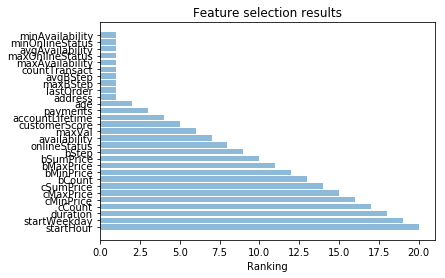

In [0]:
import matplotlib.pyplot as plt
feature_select_objects = feature_select_pd.index.values
y_pos = np.arange(len(feature_select_objects))
performance = feature_select_pd['Ranking'].sort_values(ascending=False)

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, feature_select_objects)
plt.xlabel('Ranking')
plt.title('Feature selection results')

plt.show()